# Reddit Legal Questions - Retrieving and Summarizing Similar Questions
This notebook explores using an LLM to augment and enhance the results of semantic search

**Outline:**
* Data was pulled from kaggle and is a random sample of 5k rows from "reddit legal questions"
    * Primary attributes are:
        * `body` text narrative of the legal question
        * `title` title given by OP
        * `text_label` label provided by reddit
        * `full_link` link to the reddit post
    * Features created:
        * `kmeans_label` results from K-Means clustering of document embeddings. `n_clusters` = 11 to match the `text_label` in the raw data
        * `topic_title` is LLM derived title for the cluster label
        * `llm_title` concise row-level summary generated by LLM
        * `state` fake data just for testing
* General Workflow:
    * Given a legal question, query top n most similar questions
    * Filter &/or re-rank the results
    * Pass the new question + relevant context and have LLM summarize the similarities
* Methods Tested:
    1. Query top n -> LLM re-rank & filter -> Summarize with citations
    2. Query top n -> Summarize each result with LLM -> embed summaries -> cosine re-rank -> Pass max context to LLM for summarization with citations
    3. Try `gpt-3.5-turbo` and `gpt-4` on both of the above

In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from dotenv import load_dotenv
from IPython.display import Markdown, display, HTML

In [17]:
# For specific functions in the notebook
import openai
import langchain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.embeddings import HuggingFaceInstructEmbeddings, OpenAIEmbeddings
import nltk
import tiktoken
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pdoub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# UDFs
from token_catcher import Usage
from semantic_search import SemanticSearch

In [4]:
load_dotenv()

True

* K-Means, `llm_title`, and adding fake states were done previously

In [5]:
df = pd.read_parquet("reddit_legal_cluster_test_results.parquet")

In [8]:
# df.to_csv("reddit_legal_cluster_test_results.csv", index=False)

In [6]:
df['timestamp'] = pd.to_datetime(df['created_utc'], unit='s')
df['datestamp'] = df['timestamp'].dt.date

In [7]:
print(df.shape)
df.head(2)

(5000, 16)


,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp
1078,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,"[9.475638042064453e-05, 0.0005111666301983955,...",493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10
2098,2098,1577442453,https://www.reddit.com/r/legaladvice/comments/...,eg9ll2,"Hi everyone, thanks in advance for any guidanc...","Speeding ticket in Tennessee, Georgia Driver's...",driving,4,"[-0.006706413111028856, 0.020911016696181495, ...",252,"""Speeding ticket consequences for out-of-state...",KY,10,Legal Topics in Traffic Violations,2019-12-27 10:27:33,2019-12-27


* Clusters from K-Means + LLM Labeling

In [8]:
df.topic_title.value_counts()

topic_title
Legal Topics in Rental Properties           648
Employment Legal Concerns and Issues        617
Child Custody and Related Issues            576
Legal Consequences of False Accusations     567
Rental Property and Landlord Matters        523
Compilation of Legal Topics                 461
Legal Issues in Consumer Protection         384
Legal Topics in Traffic Violations          343
Car Accident Liability and Insurance        336
COVID-19 Employment and Benefit Concerns    277
Legal Issues in Estate Administration       268
Name: count, dtype: int64

In [9]:
# Formatter to convert numbers into 'k' format
def thousands_formatter(x, pos):
    return f'{x * 1e-3}k'

def heatmap_cooccurences(df, col1, col2):
    # Create a co-occurrence matrix
    cooccurrence_matrix = pd.crosstab(df[col1], df[col2])
    
    # Generate heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cooccurrence_matrix, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={'format': FuncFormatter(thousands_formatter)})
    plt.show()

* Overview of k-Means vs. Reddit labels from raw data

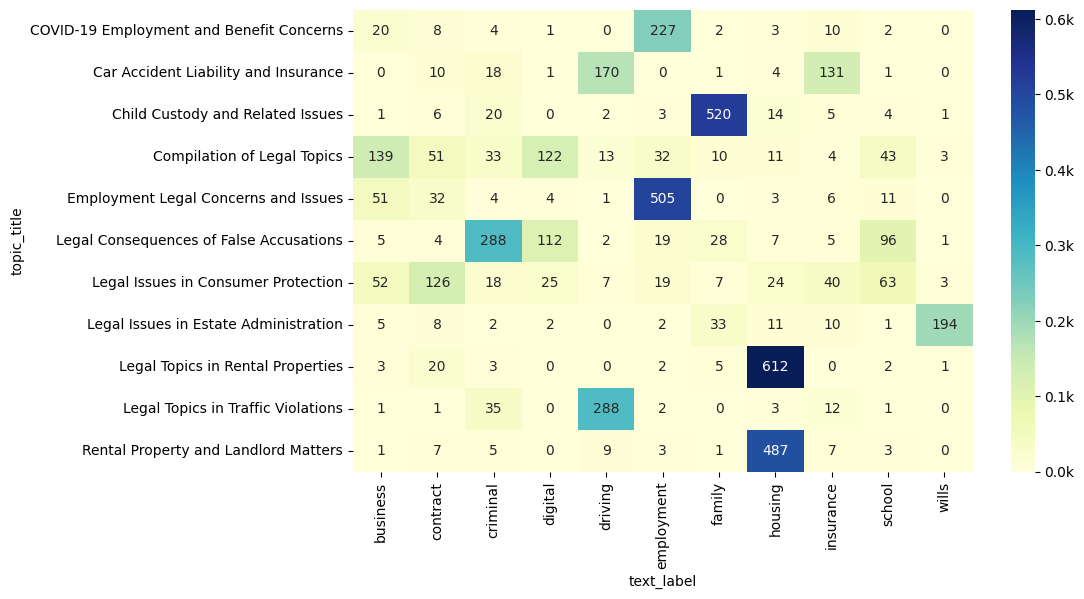

In [10]:
heatmap_cooccurences(df, "topic_title", "text_label")

* Get a sample legal question to use as a test query for our first experiment

In [11]:
test_query = df['body'].tail(1).tolist()[0]
print(test_query)

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!


* Test top n search
* The `similarity_threshold` param is to avoid returning the same text as the query

In [12]:
search_engine = SemanticSearch(df)

In [13]:
top_n = 5
filter_criteria = None
use_cosine_similarity = False
similarity_threshold = 0.93

In [14]:
test_res = search_engine.query_similar_documents(
    test_query, 
    top_n, 
    filter_criteria, 
    use_cosine_similarity,
    similarity_threshold,
)

In [76]:
print(f"df shape: {test_res.shape}")
test_res.head(5)

df shape: (5, 17)


,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp,sim_score
8236,8236,1421900108,https://www.reddit.com/r/legaladvice/comments/...,2t9664,"So, recently I've been getting a bit stale at ...",Independent Contractor: Things to Watch Out Fo...,contract,1,"[0.004767628551109627, -0.030685936228185846, ...",223,"""Legal considerations for becoming an independ...",CT,6,Compilation of Legal Topics,2015-01-22 04:15:08,2015-01-22,0.708657
1253,1253,1425525631,https://www.reddit.com/r/legaladvice/comments/...,2xzeee,I have an idea for a computer program/ app. I...,Advice on steps I can take to protect my idea ...,digital,3,"[0.008125816788076095, -0.032150854676356394, ...",132,"""Protecting your idea while collaborating with...",IA,6,Compilation of Legal Topics,2015-03-05 03:20:31,2015-03-05,0.687735
4123,4123,1590286244,https://www.reddit.com/r/legaladvice/comments/...,gphir8,I am currently self-employed in the US (Washin...,Looking to outsource work to a foreign friend....,employment,5,"[-0.004382794968609074, -0.011817069455330724,...",287,Determining the Classification of a Video Edit...,NM,6,Compilation of Legal Topics,2020-05-24 02:10:44,2020-05-24,0.672128
1270,1270,1576261884,https://www.reddit.com/r/legaladvice/comments/...,ea7t71,"Location: PA, USA\n\nOkay, so I'm 19 and a ful...",What are my best steps to form a business?,business,0,"[0.020766298313308337, -0.004717233808402397, ...",206,"""Forming an LTD for a graphic artist and game ...",MP,6,Compilation of Legal Topics,2019-12-13 18:31:24,2019-12-13,0.664517
906,906,1516676156,https://www.reddit.com/r/legaladvice/comments/...,7sbd0a,I’m the founder of my own startup. I have alre...,Is this legal to do? Paying contractors in my ...,business,0,"[0.008001127128913548, -0.0330894061622975, 0....",174,"""Legal implications of not paying a contractor...",HI,8,Employment Legal Concerns and Issues,2018-01-23 02:55:56,2018-01-23,0.663301


* The first row shown above confirms the uer query is not returned with top n results

In [19]:
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS

* Convert data from the df to a LangChain `Document` object

In [32]:
# LangChain Document objects
lc_docs = []
for i, row in df.iterrows():
    doc = langchain.docstore.document.Document(
        # embedding=row['embeddings'].tolist(),
        page_content=row['body'],
        metadata={"id_": row["id"],
                  "URL": row['full_link'],
                  "topic_title": row['topic_title'],
                  "case_title": row['llm_title'],
                  "text_label": row['text_label'],
                  "state": row['State'],
                  "date": str(row['datestamp'])},
        lookup_index=i,
    )
    lc_docs.append(doc)

In [33]:
len(lc_docs), type(lc_docs)

(5000, list)

In [83]:
# Maunually get list of text & embedding pairs, and metadata dicts
metadatas = []
for i, row in df.iterrows():
        metadata={"id_": row["id"],
                  "URL": row['full_link'],
                  "topic_title": row['topic_title'],
                  "case_title": row['llm_title'],
                  "text_label": row['text_label'],
                  "state": row['State'],
                  "date": str(row['datestamp'])}
        metadatas.append(metadata)

embeddings = OpenAIEmbeddings()
text_embeddings = df['embeddings'].tolist()
texts = df['body'].tolist()
ids = df['id'].tolist()
text_embedding_pairs = list(zip(texts, text_embeddings))
id_to_text_map = list(zip(ids, texts))
lc_faiss_index = FAISS.from_embeddings(text_embedding_pairs, embeddings, metadatas=metadatas, ids=ids)

In [74]:
lc_faiss_index.save_local("lc_faiss_index")

In [82]:
res = lc_faiss_index.similarity_search_with_score(test_query, k=5)
res

[(Document(page_content='Hey folks;\n\nI\'m currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I\'ll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.\n\nSo, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I\'m located in Ohio but will likely need to hire contractors from different states, maybe even different countries.\n\nAny advice would be appreciated. Thanks!', metadata={'id_': 'gilww3', 'URL': 'https://www.reddi

In [87]:
import llama_index

In [94]:
nodes = []
for i, row in df.iterrows():
    node = llama_index.schema.TextNode(
        embedding=row['embeddings'].tolist(),
        id_=row['index'],
        metadata={"URL": row['full_link'],
                    "topic_title": row['topic_title'],
                    "case_title": row['llm_title'],
                    "state": row['State'],
                    "date": str(row['datestamp'])},
        text=row['body'],
        excluded_embed_metadata_keys=['source', 'state', 'date'],
        lookup_index=i,
    )
    nodes.append(node)

In [95]:
len(nodes), type(nodes)

(5000, list)

In [96]:
nodes[0].metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/',
 'topic_title': 'Employment Legal Concerns and Issues',
 'case_title': '"Validity of Schedule II Drug Prescription in Texas: When does it expire?"',
 'state': 'PR',
 'date': '2019-12-10'}

In [97]:
from llama_index import VectorStoreIndex, ServiceContext

llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

In [98]:
index = VectorStoreIndex(nodes, service_context=service_context)

In [99]:
li_retriever = index.as_retriever()

In [100]:
res = li_retriever.retrieve(test_query)
res

[NodeWithScore(node=TextNode(id_='8627', embedding=[0.010599094232140971, -0.01940659953784975, -0.022989777390714138, -0.03837555943072418, 0.008253617047960292, 0.022292289439365356, -0.0248771006879766, 3.5766602393381734e-05, 0.012951409186528432, -0.03161949228914361, 0.047620705312730834, -0.004328533455289576, -0.004444781602401465, 0.0005312368633700117, 0.006482542829132275, -0.006352618675945547, 0.023837705599837652, 0.005299547116070486, -0.0019471562312935032, 1.260111614495689e-05, -0.029103062467890402, -0.004964479146470936, 0.020733195875834387, -0.01544048699563196, -0.016671349894108883, -0.018873225522044162, 0.017710744982247825, -0.003603692094807284, 0.005873949615761873, -0.02252478480226658, 0.03421797907816841, -0.0024429202990707273, -0.00019285649958059422, -0.020459672029047367, -0.025205330421708087, -0.0012428293455847487, 0.012219730521500638, 0.014442120391378814, 0.02404284801926664, 0.0015283210364634273, 0.019912620610183104, 0.0037814834334091467, -

In [103]:
print(res[0].node.text)

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!


In [105]:
res[0].node.metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/',
 'topic_title': 'Compilation of Legal Topics',
 'case_title': '"Protecting Intellectual Property and Ensuring Payment: Legal Considerations for Hiring Independent Contractors in the Video Game Industry"',
 'state': 'OR',
 'date': '2020-05-12'}

## Method 1:

* Function to query top n and convert results for use with LlamaIndex downstream

In [256]:
# from llama_index.schema import Document

# def get_top_n_docs(query: str, df: pd.DataFrame, top_n: int):
#     """Runs top n and returns result as a list of LlamaIndex Document objects"""
#     search_engine = SemanticSearch(df)
#     res = search_engine.query_similar_documents(
#         query, 
#         top_n=top_n, 
#         filter_criteria=None,
#         use_cosine_similarity = True,
#         similarity_threshold=0.95)
    
#     docs = []
#     for i, row in res.iterrows():
#         doc = Document(
#             # embedding=row['embeddings'].tolist(),
#             id_=row['index'],
#             metadata={"URL": row['full_link'],
#                       "topic_title": row['topic_title'],
#                       "case_title": row['llm_title'],
#                       "state": row['State'],
#                       "date": str(row['datestamp'])},
#             text=row['body'],
#             excluded_embed_metadata_keys=['source', 'state', 'date'],
#             lookup_index=i,
#         )
#         docs.append(doc)
#     return docs    

In [257]:
# docs = get_top_n_docs(test_query, df, 10)

* `TextNode` metadata example

In [258]:
# docs[0].metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/',
 'topic_title': 'Compilation of Legal Topics',
 'case_title': '"Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"',
 'state': 'CT',
 'date': '2015-01-22'}

In [259]:
# print(docs[0].text)

So, recently I've been getting a bit stale at my old job, working in software development at a University and was looking for something new. A group of guys are working on a startup for a software product and are ready to bring it closer to testing (beta) stage, but need some help with some software development. They saw my LinkedIn, saw my resume, and want to hire me.

Here's the kicker: they want to hire me as an independent contractor. The company is not incorporated yet, they're hoping to get into an accelerator that will help and pay for them to incorporate. They offered to pay all of my self-employment taxes as a contractor, and also formulate the agreement so I am not liable for mistakes after my contract is over in exchange for giving them the copyright to my code.

I'm supposed to be expecting a first agreement of the draft within 24 hours. What are some gotchas or other items I should watch out for based on your experiences? What legal steps can I take to avoid a potentially 

* Set up for LLM metadata extraction
* Here we will add keywords and a summary to each `TextNode`

In [109]:
SUMMARY_EXTRACT_TEMPLATE = """\
You are an actuarial documentation specialist. You're helping me summarize legal questions related to insurance. \
Using the following scenario, write a comprehensive fact-based summary that focuses on insurance and legal topics.\n\nDESCRIPTIONS: {context_str}\n\nSUMMARY:"""

In [113]:
from llama_index.node_parser import SimpleNodeParser
from llama_index.node_parser.extractors import (
    MetadataExtractor,
    SummaryExtractor,
    KeywordExtractor,
)

llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo", max_tokens=512)
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

metadata_extractor = MetadataExtractor(
    extractors=[
        SummaryExtractor(summaries=["self"],
                         prompt_template=SUMMARY_EXTRACT_TEMPLATE),
        KeywordExtractor(keywords=5),
    ],
)

node_parser = SimpleNodeParser(
    metadata_extractor=metadata_extractor,
)

In [114]:
li_docs = []
for i, row in df.iterrows():
    doc = llama_index.schema.Document(
        id_=row['index'],
        metadata={"URL": row['full_link'],
                  "topic_title": row['topic_title'],
                  "case_title": row['llm_title'],
                  "state": row['State'],
                  "date": str(row['datestamp'])},
        text=row['body'],
        excluded_embed_metadata_keys=['URL', 'state', 'date'],
        lookup_index=i,
    )
    li_docs.append(doc)

In [115]:
len(li_docs)

5000

In [116]:
usage = Usage()
nodes = node_parser.get_nodes_from_documents(li_docs)
print(f"Token Cost: ${usage.total_tokens()/1000*0.002:.4f}")

Token Cost: $7.5335


In [118]:
li_vec_index = VectorStoreIndex(nodes, service_context=service_context)

In [119]:
li_vec_index.storage_context.persist("li_vec_index")

In [120]:
SUMMARY_QUERY = (
    "You are an actuarial documentation specialist. You're helping me summarize legal questions related to insurance. "
    "Write a comprehensive fact-based summary of this document that focuses on insurance and legal topics. "
)

In [121]:
from llama_index import get_response_synthesizer
from llama_index.indices.document_summary import DocumentSummaryIndex

usage = Usage()

llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo", max_tokens=512)
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

response_synthesizer = get_response_synthesizer(
    response_mode="simple_summarize",
)
doc_summary_index = DocumentSummaryIndex.from_documents(
    li_docs,
    summary_query=SUMMARY_QUERY,
    service_context=service_context,
    response_synthesizer=response_synthesizer,
)

print(f"Token Cost: ${usage.total_tokens()/1000*0.002:.4f}")

current doc id: 1078
current doc id: 2098
current doc id: 9384
current doc id: 5425
current doc id: 7735
current doc id: 5239
current doc id: 8198
current doc id: 5820
current doc id: 7557
current doc id: 457
current doc id: 251
current doc id: 6486
current doc id: 3319
current doc id: 1056
current doc id: 5950
current doc id: 4534
current doc id: 2614
current doc id: 2698
current doc id: 8153
current doc id: 1142
current doc id: 1090
current doc id: 7377
current doc id: 8191
current doc id: 2954
current doc id: 5663
current doc id: 3721
current doc id: 7964
current doc id: 7627
current doc id: 119
current doc id: 6121
current doc id: 6253
current doc id: 1791
current doc id: 1608
current doc id: 4614
current doc id: 9366
current doc id: 2348
current doc id: 8766
current doc id: 1175
current doc id: 2132
current doc id: 7502
current doc id: 668
current doc id: 8486
current doc id: 624
current doc id: 3445
current doc id: 6711
current doc id: 7897
current doc id: 3202
current doc id: 94

In [122]:
doc_summary_index.storage_context.persist("summary_index")

In [123]:
from llama_index.indices.loading import load_index_from_storage
from llama_index import StorageContext

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir="summary_index")
doc_summary_index_ = load_index_from_storage(storage_context)

In [125]:
# https://gpt-index.readthedocs.io/en/stable/core_modules/query_modules/response_synthesizers/usage_pattern.html

query_engine = doc_summary_index.as_query_engine(
)

* Using IDs from the df index make things easier

In [262]:
for i in range(len(nodes)):
    nodes[i].id_ = li_docs[i].id_

* Summary & keywords extracted by the LLM

In [127]:
print(nodes[0].get_metadata_str())

URL: https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/
topic_title: Employment Legal Concerns and Issues
case_title: "Validity of Schedule II Drug Prescription in Texas: When does it expire?"
state: PR
date: 2019-12-10
section_summary:  A person applied for a job and was given an offer letter, with the only remaining variable being a drug test. The person takes Adderall, which is a Schedule II drug, and has a valid prescription from their doctor. However, the doctor administering the drug test refused to accept the prescription, claiming it was too old. The person's doctor provided additional documentation to explain that the prescription was valid, but the employer then put a "hiring freeze" in place and the position was not filled. This raises the question of when a Schedule II drug is no longer considered valid in Texas.
excerpt_keywords: 
Adderall, Prescription, Drug Test, Texas, Scheduled II Drug


In [128]:
nodes[0].metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/',
 'topic_title': 'Employment Legal Concerns and Issues',
 'case_title': '"Validity of Schedule II Drug Prescription in Texas: When does it expire?"',
 'state': 'PR',
 'date': '2019-12-10',
 'section_summary': ' A person applied for a job and was given an offer letter, with the only remaining variable being a drug test. The person takes Adderall, which is a Schedule II drug, and has a valid prescription from their doctor. However, the doctor administering the drug test refused to accept the prescription, claiming it was too old. The person\'s doctor provided additional documentation to explain that the prescription was valid, but the employer then put a "hiring freeze" in place and the position was not filled. This raises the question of when a Schedule II drug is no longer considered valid in Texas.',
 'excerpt_keywords': '\nAdderall, Prescription, Drug Test, Texas, Scheduled

In [283]:
from llama_index import (
    VectorStoreIndex,
    ServiceContext,
    QueryBundle,
)
from llama_index.indices.postprocessor import LLMRerank
from llama_index.query_engine import CitationQueryEngine
from llama_index.llms import OpenAI
from IPython.display import Markdown, display

llm = OpenAI(temperature=0.0, model="gpt-3.5-turbo")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

* Custom retriever that can optionally post-filter with LLM

In [284]:
index = VectorStoreIndex(nodes, service_context=service_context)

In [285]:
from llama_index.retrievers import VectorIndexRetriever

def get_retrieved_nodes(
    query_str, vector_top_k=10, reranker_top_n=3, with_reranker=False
):
    query_bundle = QueryBundle(query_str)
    # configure retriever
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=vector_top_k,
    )
    retrieved_nodes = retriever.retrieve(query_bundle)

    if with_reranker:
        # configure reranker
        reranker = LLMRerank(
            choice_batch_size=5, top_n=reranker_top_n, service_context=service_context
        )
        retrieved_nodes = reranker.postprocess_nodes(retrieved_nodes, query_bundle)

    return retrieved_nodes

* Get top 10 most similar with no re-ranking

In [286]:
new_nodes = get_retrieved_nodes(
    test_query,
    vector_top_k=10,
    reranker_top_n=5,
    with_reranker=False,
)

print(len(new_nodes))

10


* Use LLM to re-rank results and filter down to top 5 best matches

In [287]:
new_nodes = get_retrieved_nodes(
    test_query,
    vector_top_k=20,
    reranker_top_n=5,
    with_reranker=True,
)

print(len(new_nodes))

5


* Example output showing similarity scores

In [288]:
new_nodes[0]

NodeWithScore(node=TextNode(id_='1253', embedding=None, metadata={'URL': 'https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/', 'topic_title': 'Compilation of Legal Topics', 'case_title': '"Protecting your idea while collaborating with strangers in the California Bay Area tech scene"', 'state': 'IA', 'date': '2015-03-05', 'section_summary': '\n\nThe section discusses an idea for a computer program/app and the need to find others to help turn it into a working product. The speaker is worried that someone with the know-how to implement the idea could cut them out. The speaker is looking for options to protect themselves when talking to strangers and is located in the California Bay Area, where there is a good chance of finding tech-savvy people.', 'excerpt_keywords': '\nComputer Program, App, Research, Protection, California Bay Area'}, excluded_embed_metadata_keys=['source', 'state', 'date'], excluded_llm_metadata_keys=[], relationships

* Convert the `NodeWithScore` returned from the initial retrtieval back to "nornal nodes"
* LLM re-ranking and citation summarization can be done together, but step-wise is easier to "tune" and debug

In [289]:
new_text_nodes = [node.node for node in new_nodes]

In [290]:
new_text_nodes[0]

TextNode(id_='1253', embedding=None, metadata={'URL': 'https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/', 'topic_title': 'Compilation of Legal Topics', 'case_title': '"Protecting your idea while collaborating with strangers in the California Bay Area tech scene"', 'state': 'IA', 'date': '2015-03-05', 'section_summary': '\n\nThe section discusses an idea for a computer program/app and the need to find others to help turn it into a working product. The speaker is worried that someone with the know-how to implement the idea could cut them out. The speaker is looking for options to protect themselves when talking to strangers and is located in the California Bay Area, where there is a good chance of finding tech-savvy people.', 'excerpt_keywords': '\nComputer Program, App, Research, Protection, California Bay Area'}, excluded_embed_metadata_keys=['source', 'state', 'date'], excluded_llm_metadata_keys=[], relationships={<NodeRelationship

* Example of what LLM sees

In [291]:
from llama_index.schema import MetadataMode

print(new_text_nodes[1].get_content(metadata_mode=MetadataMode.LLM))

[Excerpt from document]
URL: https://www.reddit.com/r/legaladvice/comments/51psea/kickstarter_for_a_tabletop_rpg_book_do_i_need_an/
topic_title: Compilation of Legal Topics
case_title: "Legal considerations for launching a Kickstarter campaign and selling a self-published book online"
state: FM
date: 2016-09-08
section_summary: 

This section discusses the potential need for an LLC when launching a Kickstarter for a tabletop RPG book. It also covers the potential need to pay self-employment tax and income tax, as well as the risk of personal assets being seized if someone were to sue over the book. The author expresses concern over the cost of an LLC and the potential for people to try to take advantage of them.
excerpt_keywords: 
Tabletop RPG, Kickstarter, LLC, Self-Employment Tax, Intellectual Property
Excerpt:
-----
So I'm in Texas and I'm planning on launching a Kickstarter for my tabletop rpg book. Everything is my own including the art, writing ideas, etc. So I'm not asking about

* Create a temporary `llm_filtered_index` to pass into the final `CitationQueryEngine`

In [292]:
llm_filtered_index = VectorStoreIndex(new_text_nodes, service_context=service_context)

* Custom citation prompt 
* `gpt-3.5-turbo` can at times struggle with the notation
* `gpt-4` is reliable

In [293]:
from llama_index import Prompt

CITATION_TEMPLATE = Prompt(
    "Please provide an answer based solely on the provided sources. "
    "When referencing information from a source, "
    "cite the appropriate source using its corresponding number and URL. "
    "Every answer should include at least one source citation. "
    "Only cite a source when you are explicitly referencing it. "
    "For example:\n"
    "[1]:\n"
    "URL: source_1_address.com\n"
    "Excerpt:\n-----\nThe sky is red in the evening and blue in the morning.\n"
    "[2]:\n"
    "URL: source_2_address.com\n"
    "Excerpt:\n-----\nWater is wet when the sky is red.\n"
    "Query: When is water wet?\n"
    "Answer: Water will be wet when the sky is red [2](source_2_address.com), "
    "which occurs in the evening [1](source_1_address.com).\n"
    "Now it's your turn. Below are several sources of information. Make sure to cite the information using [[number](URL)] notation:"
    "\n------\n"
    "{context_str}"
    "\n------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [294]:
k = len(new_text_nodes) # No filtering for this step

citation_query_engine = CitationQueryEngine.from_args(
    llm_filtered_index,
    citation_qa_template=CITATION_TEMPLATE,
    similarity_top_k=k,
    citation_chunk_size=1024,
)

In [295]:
prompt = f"Summarize how the information is relevant to the question. Summarize similarities, and include a bullet point list of specific examples.\n\nQUESTION: {test_query}"
print(prompt)

Summarize how the information is relevant to the question. Summarize similarities, and include a bullet point list of specific examples.

QUESTION: Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even dif

In [296]:
response = citation_query_engine.query(prompt)

In [297]:
# Print helper
def print_nodes(response, new_text_nodes):
    k = len(new_text_nodes)
    count = 1
    for i in range(k):
        # add index
        title = response.source_nodes[i].node.metadata['case_title']
        link = f"{response.source_nodes[i].node.metadata['URL']}"
        venue = response.source_nodes[i].node.metadata['state']
        date = response.source_nodes[i].node.metadata['date']
        display(Markdown(f"#### {[count]} [{title}]({link}) - {venue}, {date}"))
        count+=1

In [298]:
# Make keywords more standard
def normalize_keywords(keywords):
    lemmatizer = WordNetLemmatizer()
    normalized_keywords = []
    for keyword in keywords:
        # Remove line breaks
        keyword = re.sub('\n', ' ', keyword)
        # Tokenize the keyword
        tokens = word_tokenize(keyword)
        # Lemmatize each word in the keyword
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # Join the lemmatized tokens back into a string and lowercase each word
        normalized_keyword = ' '.join(lemmatized_tokens).lower()
        normalized_keywords.append(normalized_keyword)
        
    return ", ".join(normalized_keywords)

In [299]:
# Get keywords from metadata
source_node_kwds = [source.node.metadata['excerpt_keywords'] for source in new_nodes]
# Clean keywords
sim_case_kwds = normalize_keywords(source_node_kwds)

## Method 1 Results:
### GPT-3.5-Turbo
* Used for re-ranking, filtering, and final response

In [300]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{test_query}"))
display(Markdown(f"## Model Output:"))
display(Markdown(f"{response.response}"))
display(Markdown(f"### **Sources:**"))
print_nodes(response, new_text_nodes)
display(Markdown(f"##### **Keyword Tags:** {sim_case_kwds}"))

## New Query:

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!

## Model Output:

Based on the provided sources, there are several relevant pieces of information that can be applied to the question:

1. Source 1 discusses a group of college students who started a tech-based project for a large business entity. They formed an LLC to protect themselves and their intellectual property [1](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/).

2. Source 2 discusses the concern of protecting an idea while collaborating with strangers in the California Bay Area tech scene. The speaker is worried about someone with the know-how stealing their idea. They are looking for options to protect themselves when talking to strangers [2](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/).

3. Source 3 discusses the classification of a video editor as an independent contractor or employee. The individual in the US wants to outsource work to a friend in South Africa. They would pay a flat rate for each project and the friend would be responsible for their own costs. The key topics discussed are the classification of the friend and the responsibilities of both parties [3](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/).

4. Source 4 discusses structuring a temporary agreement for equity split and revenue share in a startup partnership. The founder and a brand designer want to split equity and revenue share. They are looking for a template to structure the agreement [4](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/).

5. Source 5 discusses the legal considerations for launching a Kickstarter campaign and selling a self-published book online. The author is concerned about the need for an LLC, self-employment tax, and the risk of personal assets being seized. They are also worried about potential lawsuits and protecting their intellectual property [5](https://www.reddit.com/r/legaladvice/comments/51psea/kickstarter_for_a_tabletop_rpg_book_do_i_need_an/).

Based on these sources, the individual designing the video game should consider the following:

1. Forming a legal entity, such as an LLC, to protect their intellectual property and provide a framework for contracts [1](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/).

2. When collaborating with strangers, consider options for protecting their idea, such as non-disclosure agreements or confidentiality agreements [2](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/).

3. When hiring independent contractors, determine the classification of the contractors (independent contractor or employee) and clearly outline the responsibilities and payment terms in a contract [3](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/).

4. When entering into a partnership or equity split agreement, create a written agreement that clearly outlines the terms and responsibilities of each party [4](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/).

5. Consider the legal considerations of launching a crowdfunding campaign, such as the need for an LLC, tax obligations, and protecting intellectual property [5](https://www.reddit.com/r/legaladvice/comments/51psea/kickstarter_for_a_tabletop_rpg_book_do_i_need_an/).

By incorporating these considerations and seeking legal advice, the individual can better protect their intellectual property and ensure that contractors are paid for their work.

### **Sources:**

#### [1] [Navigating Legal Contracts: Protecting Your Business and Seeking Legal Support](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/) - LA, 2015-03-01

#### [2] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05

#### [3] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24

#### [4] ["Structuring a temporary agreement for equity split and revenue share in a startup partnership"](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/) - VA, 2019-12-04

#### [5] ["Legal considerations for launching a Kickstarter campaign and selling a self-published book online"](https://www.reddit.com/r/legaladvice/comments/51psea/kickstarter_for_a_tabletop_rpg_book_do_i_need_an/) - FM, 2016-09-08

##### **Keyword Tags:** computer program , app , research , protection , california bay area, tabletop rpg , kickstarter , llc , self-employment tax , intellectual property, independent contractor , self-employed , youtube , twitch , south africa, equity split agreement , brand designer , freelancer , revenue share , 2020-2021, legal , contract , business , protection , corporation

## Method 1 Results:
### GPT-4
* Used for re-ranking, filtering, and final response

In [106]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{test_query}"))
display(Markdown(f"## Model Output:"))
display(Markdown(f"{response.response}"))
display(Markdown(f"### **Sources:**"))
print_nodes(response, new_text_nodes)
display(Markdown(f"##### **Keyword Tags:** {sim_case_kwds}"))

## New Query:

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!

## Model Output:

The information provided in the sources is relevant to your question as they discuss various legal considerations when hiring independent contractors, protecting intellectual property, and forming a business. 

Similarities across the sources include the need for legal protection when dealing with independent contractors and the importance of clear contracts to ensure payment and protect intellectual property. 

Specific examples include:

- A software development startup hiring an independent contractor and ensuring they are not liable for mistakes after the contract is over in exchange for giving the company the copyright to their code [1](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/).
- A group of college students starting a tech-based project and seeking legal advice on how to protect themselves when signing a contract with a large business entity [2](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/).
- An individual seeking advice on how to protect their idea for a computer program/app when collaborating with strangers [3](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/).
- A graphic designer in Texas outlining a payment schedule in their terms and conditions to ensure they get paid for their work [4](https://www.reddit.com/r/legaladvice/comments/7x69a3/im_writing_my_own_contract_for_freelance_work_and/).
- A 19-year-old graphic artist and game designer seeking advice on forming an LTD to release video games on larger publication platforms and apply for business loans [5](https://www.reddit.com/r/legaladvice/comments/ea7t71/what_are_my_best_steps_to_form_a_business/). 

Based on these examples, you may want to consider drafting a contract that clearly outlines payment terms, project timelines, and copyright ownership. You may also want to seek legal advice to ensure your intellectual property is protected.

### **Sources:**

#### [1] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22

#### [2] [Navigating Legal Contracts: Protecting Your Business and Seeking Legal Support](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/) - LA, 2015-03-01

#### [3] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05

#### [4] ["Clarifying payment schedule in graphic designer's terms and conditions in Texas"](https://www.reddit.com/r/legaladvice/comments/7x69a3/im_writing_my_own_contract_for_freelance_work_and/) - IA, 2018-02-13

#### [5] ["Forming an LTD for a graphic artist and game designer: business structure, name reservation, and financial implications"](https://www.reddit.com/r/legaladvice/comments/ea7t71/what_are_my_best_steps_to_form_a_business/) - MP, 2019-12-13

##### **Keyword Tags:** software development , startup , independent contractor , self-employment taxes , copyright, legal , contract , business , protection , corporation, ltd , business , paypal , loans , taxation, computer program , app , research , protection , california bay area, payment schedule , project cost , down payment , rush fee , timeline

In [89]:
df.head(1)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp
1078,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,"[9.475638042064453e-05, 0.0005111666301983955,...",493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10


## Method 2:

* Helper to query top n from df

In [301]:
def get_top_n(df: pd.DataFrame, query: str, top_n: int):
    search_engine = SemanticSearch(df)
    res = search_engine.query_similar_documents(
        query, 
        top_n=top_n, 
        filter_criteria=None,
        use_cosine_similarity = True,
        similarity_threshold=0.95)
    return res

In [302]:
df_res = get_top_n(
    df=df,
    query=test_query,
    top_n=20
)

* Summarizer Model to compress top n results

In [305]:
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)


system_template = "You are an actuarial documentation specialist. You're helping me summarize legal questions related to insurance."
human_template = "Using the following scenario, write a concise summary that focuses on insurance and legal topics.\n\nDESCRIPTIONS:{text}\n\nSUMMARY:"

prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ],
    input_variables=["text"],
)
    
chain = LLMChain(
    llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo", max_tokens=512), prompt=prompt, verbose=False
)

In [306]:
def get_summary(input_text: str):
    output_text = chain.run(input_text)
    return output_text

In [307]:
test_summary = get_summary(test_query)

* Original text

In [308]:
Markdown(f"{test_query}")

Hey folks;

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds.

So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they 100% get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

Any advice would be appreciated. Thanks!

* LLM "actuarial summary"

In [309]:
Markdown(f"{test_summary}")

The individual is seeking advice on the types of contracts they can use to ensure that independent contractors/freelancers are paid for their work and to protect their intellectual property in the development of a video game. They are concerned about the possibility of contractors taking the game concept or 3D models and leaving. They are located in Ohio but may hire contractors from different states or countries.

* New test text to add variety to the experiments

In [310]:
query = df['body'].head(1).tolist()[0]
print(query)

I applied for a job and after two interviews I was given for and agreed to an offer letter, had a start date.  The only remaining variable was a drug test, which I prepared myself for by bringing all my prescriptions with me.  

I take Adderall, my doctor prescribes me for 3 pills a day, insurance pays for only two a day so that’s what I get.  2 pills a day for 30 days.  

However, I don’t need adderall everyday, so I only take it as needed.  My psychiatrist knows this and is okay with it.  I don’t take it everyday so my prescription can last me months, depending on circumstances.  

Of course, I happen to take a drug test for a possible new job the day after taking an adderall at work.  No big deal, I have a prescription and it’s never been a big deal in the past.  

Except this time it was.  According to the doctor who administrated the test, my prescription was too old.  How old was it, I was prescribed in June and filled the prescription on July 8th, 2019.  I still have about a thi

In [ ]:
test_res = search_engine.query_similar_documents(
    test_query, 
    top_n, 
    filter_criteria, 
    use_cosine_similarity,
    similarity_threshold,
)

In [314]:
def get_results(df: pd.DataFrame, query: str, limit: int = 20) -> pd.DataFrame:
    search_engine = SemanticSearch(df)
    res = search_engine.query_similar_documents(
        query, 
        top_n=limit, 
        filter_criteria=None,
        use_cosine_similarity=False,
        similarity_threshold=0.90)
    return res

In [315]:
df_res = get_results(df, query)

In [318]:
print(f"df shape: {df_res.shape}")
df_res.head(2)

df shape: (20, 17)


,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp,sim_score
6191,6191,1590032420,https://www.reddit.com/r/legaladvice/comments/...,gnpjof,I applied to a small private transport company...,(NJ) I was denied a job due to being prescribe...,employment,5,"[-0.014932120068105919, -0.01118895493326352, ...",235,"""Is it discrimination if a company refuses to ...",MI,8,Employment Legal Concerns and Issues,2020-05-21 03:40:20,2020-05-21,0.709400
9156,9156,1473870804,https://www.reddit.com/r/legaladvice/comments/...,52rcpe,"I'm a Freshman adult, former Texan resident an...",(TN) I'm apparently a POI at my new Uni. Shoul...,criminal,2,"[0.01599887962418506, 0.010982281649642614, 0....",546,"""Legal advice needed: Accused of selling Xanax...",MT,9,Legal Consequences of False Accusations,2016-09-14 16:33:24,2016-09-14,0.658507


In [319]:
usage = Usage()
df_res['summary'] = df_res['body'].apply(get_summary)
print(f"Token Cost: ${usage.total_tokens()/1000*0.002:.4f}")

In [320]:
df_res['summary'].head().tolist()

["The individual applied for a job at a small private transport company and tested positive for amphetamines during the drug test. They provided a doctor's note explaining their prescription for Adderall XR 10mg for ADHD. The employer asked if they could refrain from taking their medication, to which the individual declined as it helps them function. The employer then emailed stating they were unable to hire the individual due to liability issues associated with their medications. The individual has a history of volunteering in 911 EMS without any issues while on medication. They are questioning whether the employer's actions constitute discrimination and are considering filing an ADA complaint.",
 'The individual is a college student who takes multiple prescribed medications for mental health. They recently tested positive for their medications during an ER visit. A friend informed them that their name is associated with "Persons of interest" and specifically selling Xanax in the poli

In [321]:
df_res['len_body'] = df_res['body'].str.len()
df_res['len_summary'] = df_res['summary'].str.len()

In [322]:
df_res['compress_chars'] = df_res['len_body'] - df_res['len_summary']

<Axes: >

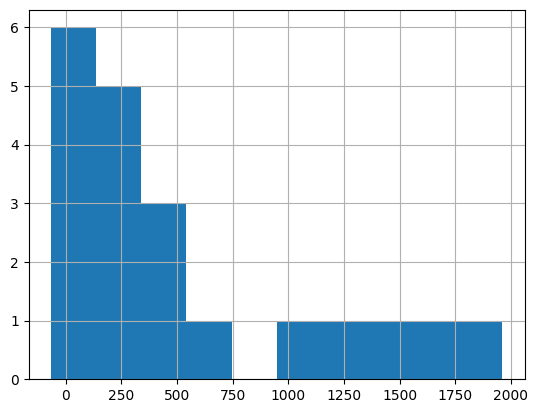

In [323]:
df_res['compress_chars'].hist()

* Using Instructor for embedding summary text

In [324]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

In [325]:
instruct_query_embeddings = HuggingFaceInstructEmbeddings(
    query_instruction="Represent the legal query for retrieving similar documents: "
)

instruct_doc_embeddings = HuggingFaceInstructEmbeddings(
    query_instruction="Represent the legal document for retrieval: "
)

c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512
load INSTRUCTOR_Transformer
max_seq_length  512


In [326]:
def preprocess_text(text: str):
    text = text.lower()
    # remove stopwords from the query
    stopwords = set(nltk.corpus.stopwords.words("english"))
    # Example of adding words to the stopwords list
    stopwords.update(["please", "review"])
    text = " ".join([word for word in text.split() if word not in stopwords])
    return text

In [327]:
from sklearn.metrics.pairwise import cosine_similarity

In [329]:
def rerank(df: pd.DataFrame, query: str, text_col_name: str) -> pd.DataFrame:
    """
    This function takes in the results of a top n semantic search and returns re-ranked df
    Performs the following steps:
        1. Process and embed query text
        2. Embed a column of text (the summaries)
        3. Calculate cosine similarity for query and summariy embeddings
        4. Sory df by similarity    
    """
    query_proc = preprocess_text(query)
    query_embedding = instruct_query_embeddings.embed_query(query_proc)
    query_embedding = np.array(query_embedding)
    query_embedding = np.expand_dims(query_embedding, axis=0)
    doc_embeddings = instruct_doc_embeddings.embed_documents(df[text_col_name].tolist())
    df["instruct_embeddings"] = list(doc_embeddings)
    df["similarity"] = cosine_similarity(query_embedding, doc_embeddings).flatten()
    # sort the dataframe by similarity
    df.sort_values(by="similarity", ascending=False, inplace=True)
    return df
    

In [330]:
rerank_res_df = rerank(df_res, query, 'summary')

In [358]:
len(rerank_res_df)

20

* 18 of the 20 summaries fit within the token limit

In [378]:
def count_tokens(text):
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    text = str(text)
    return len(encoding.encode(text))


def create_context_chatgpt(question, df, token_limit=3000):
    """
    Create a context for a question by using the most similar text from the dataframe
    """

    returns = []
    count = 1
    total_tokens = count_tokens(query)  # Start with tokens from the query
    # Add the text to the context until the context is too long
    for i, row in df.iterrows():

        # Else add it to the text that is being returned
        text = ("["
                + str(count)
                + "] "
                + row["summary"]
                + "\nURL: "
                + row["full_link"])
        text_tokens = count_tokens(text)
        if total_tokens + text_tokens > token_limit:
            break
        returns.append(text)
        total_tokens += text_tokens
        count += 1
    # Return the context
    return "\n\n".join(returns)

In [387]:
def answer_question_chatgpt(
    df,
    question=query,
    # k=5,
    instructions="""Instructions: Using the provided search results, write a detailed comarative analysis for a new query. ALWAYS cite results using [[number](URL)] notation after the reference. End your answer with a summary. \nNew Query:""",
    max_len=3000,
    debug=False,
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context_chatgpt(question, df)

    try:
        # Create a completions using the question and context
        # prompt = f'''{context} \n\n Instructions: Using the provided literature with sources, write a comprehensive reply to the given query. Make sure to cite results using [[number](URL)] notation after the reference. If the provided search results refer to multiple subjects with the same name, write separate answers for each subject. You can skip a citation which you dont find relevant to the query. \nQuery:{question}\nAnswer:'''
        prompt = f"""{context} \n\n{instructions} {question}\nAnswer:"""
        return prompt
    except Exception as e:
        print(e)
        return ""

In [388]:
# create prompt with the top 8 results
prompt = answer_question_chatgpt(rerank_res_df, 
                                 query, 
)

* Formatted prompt based on re-ranked summary text

In [381]:
print(prompt)

[1] The individual applied for a job at a small private transport company and tested positive for amphetamines during the drug test. They provided a doctor's note explaining their prescription for Adderall XR 10mg for ADHD. The employer asked if they could refrain from taking their medication, to which the individual declined as it helps them function. The employer then emailed stating they were unable to hire the individual due to liability issues associated with their medications. The individual has a history of volunteering in 911 EMS without any issues while on medication. They are questioning whether the employer's actions constitute discrimination and are considering filing an ADA complaint.
URL: https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/

[2] The individual works in aircraft maintenance and is required to undergo random drug testing as per the regulations of the Department of Transportation (DoT) and Federal Aviation Admin

In [389]:
def print_papers(df, k=8):
    count = 1
    for i in range(k):
        # add index
        title = df.iloc[i]["llm_title"]
        link = f"{df.iloc[i]['full_link']}"
        venue = df.iloc[i]["State"]
        date = df.iloc[i]["datestamp"]
        display(Markdown(f"#### {[count]} [{title}]({link}) - {venue}, {date}"))
        count+=1

In [417]:
def generate_answer(prompt):
    """Generates an answer using ChatGPT."""
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are helpful legal research assistant. Analyze the current legal question, and compare it to past cases. Using only the provided context, offer insights into how the researcher can use the past questions to address the new outstanding issue.",
            },
            {"role": "user", "content": prompt},
        ],
    )
    return response.choices[0].message.content

In [418]:
response = generate_answer(prompt)

In [413]:
# Helpers to get the cases the LLM ended up using

def extract_citation_numbers_in_brackets(text):
    matches = re.findall(r'\[(\d+)\]', text)
    return list(set(matches))


def print_cited_papers(df, citation_numbers):
    for citation in citation_numbers:
        i = int(citation) - 1  # convert string to int and adjust for indexing
        title = df.iloc[i]["llm_title"]
        link = f"{df.iloc[i]['full_link']}"
        venue = df.iloc[i]["State"]
        date = df.iloc[i]["datestamp"]
        display(Markdown(f"#### {[i+1]} [{title}]({link}) - {venue}, {date}"))


In [419]:
citation_numbers = extract_citation_numbers_in_brackets(response)

## Method 2 Results:
### GPT-4
* Was given re-ranked summary text, and instructed to use only ones that are relevant to the new query

In [416]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{query}"))
display(Markdown(f"## GPT-4 Response:"))
display(Markdown(f"{response}"))
display(Markdown(f"### **Sources:**"))
print_cited_papers(rerank_res_df, citation_numbers)

## New Query:

I applied for a job and after two interviews I was given for and agreed to an offer letter, had a start date.  The only remaining variable was a drug test, which I prepared myself for by bringing all my prescriptions with me.  

I take Adderall, my doctor prescribes me for 3 pills a day, insurance pays for only two a day so that’s what I get.  2 pills a day for 30 days.  

However, I don’t need adderall everyday, so I only take it as needed.  My psychiatrist knows this and is okay with it.  I don’t take it everyday so my prescription can last me months, depending on circumstances.  

Of course, I happen to take a drug test for a possible new job the day after taking an adderall at work.  No big deal, I have a prescription and it’s never been a big deal in the past.  

Except this time it was.  According to the doctor who administrated the test, my prescription was too old.  How old was it, I was prescribed in June and filled the prescription on July 8th, 2019.  I still have about a third of a bottle, I take adderall twice a week on average.  This doctor flipped out.  Not only did she refuse to inspect my prescription bottle when I talked to her in person, she demanded my medical records for all the prescriptions I take.  

Both of my doctors complied and when I talked to her on the phone to follow up, her exact words were “You’re prescription is too old, where are you getting it from.”  This pushed back my start date from a definite start to “wait and see” as I was still having my doctors trying to appease the drug test doctor.  

I politely tried to explain that I don’t take my adderall everyday because I don’t need to and she would no listen.  So once again, I had my psychiatrist send another letter explaining in more detail.  
I didn’t hear anything back after that, and when following up with the perspective employer and now they’re having a “hiring freeze” and won’t be filling the position.  


So, in Texas, when is a schedule II drug no longer considered valid?  

TL;DR
Doctor said my prescription was too old and I must be getting amphetamines from an illegal source.

## GPT-4 Response:

The new query presents a complex issue about the legality of prescription age and employer's actions in relation to a drug test result in Texas. Several provided legal cases may offer some guidance and insights on this matter.

Firstly, we have a similar case [[1](https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/)] where an individual with a prescription for Adderall was denied job due to "liability issues." While the circumstances are not identical, parallels can be drawn from allegations of discrimination based on the individual's use of a prescription medication. Further investigation of ADA guidelines could be beneficial to determine if the act of declining a job offer because an individual's prescription was deemed too old constitutes discrimination. 

Secondly, [[14](https://www.reddit.com/r/legaladvice/comments/4z9y31/ia_us_am_i_covered_by_the_ada_and_is_my_employer/)] introduces a similar concept where a worker's prescribed medication (meant to assist the individual's mental health condition) conflicted with their job. It raises questions about the applicability of ADA protections where prescription medication is involved. 

Finally, it is worth considering [[13](https://www.reddit.com/r/legaladvice/comments/52rcpe/tn_im_apparently_a_poi_at_my_new_uni_should_i_be/)], where legal trouble arose due to the prescribed medication appearing on a drug test. The individual was concerned about potential legal implications, which parallels with the present question.

In addressing the new query, the researcher may want to focus on the legal definitions of a valid prescription (particularly focusing on Schedule II drugs), protections under the ADA, and the rights of prospective employees in dealing with circumstances surrounding medical prescriptions and drug tests. Other considerations could include the doctor's right to request medical records and the employer's obligations when it comes to hiring freezes and how this could potentially tie into perceived discrimination. 

Comparing these to new issue can offer insights on what legal standpoints might be available. Keep in mind the direct focus on the Schedule II drug regulation and prescription validity, and how the reasoning behind ADA related cases can work hand-in-hand with this case. It is important to understand the specific state laws regarding drug prescription validity, and specifically for Texas, as well as federal laws and how they interact with ADA regulations.

### **Sources:**

#### [13] ["Legal advice needed: Accused of selling Xanax, how to handle the situation and protect my rights?"](https://www.reddit.com/r/legaladvice/comments/52rcpe/tn_im_apparently_a_poi_at_my_new_uni_should_i_be/) - MT, 2016-09-14

#### [14] ["ADA and Employment: Can an employer penalize an employee for missing work due to a disability-related panic attack?"](https://www.reddit.com/r/legaladvice/comments/4z9y31/ia_us_am_i_covered_by_the_ada_and_is_my_employer/) - UT, 2016-08-24

#### [1] ["Is it discrimination if a company refuses to hire me due to my prescribed medication?"](https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/) - MI, 2020-05-21

## Method 2 Results:
### GPT-3.5-Turbo
* Same set up as above

In [420]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{query}"))
display(Markdown(f"## GPT-3.5-turbo Response:"))
display(Markdown(f"{response}"))
display(Markdown(f"### **Sources:**"))
print_cited_papers(rerank_res_df, citation_numbers)

## New Query:

I applied for a job and after two interviews I was given for and agreed to an offer letter, had a start date.  The only remaining variable was a drug test, which I prepared myself for by bringing all my prescriptions with me.  

I take Adderall, my doctor prescribes me for 3 pills a day, insurance pays for only two a day so that’s what I get.  2 pills a day for 30 days.  

However, I don’t need adderall everyday, so I only take it as needed.  My psychiatrist knows this and is okay with it.  I don’t take it everyday so my prescription can last me months, depending on circumstances.  

Of course, I happen to take a drug test for a possible new job the day after taking an adderall at work.  No big deal, I have a prescription and it’s never been a big deal in the past.  

Except this time it was.  According to the doctor who administrated the test, my prescription was too old.  How old was it, I was prescribed in June and filled the prescription on July 8th, 2019.  I still have about a third of a bottle, I take adderall twice a week on average.  This doctor flipped out.  Not only did she refuse to inspect my prescription bottle when I talked to her in person, she demanded my medical records for all the prescriptions I take.  

Both of my doctors complied and when I talked to her on the phone to follow up, her exact words were “You’re prescription is too old, where are you getting it from.”  This pushed back my start date from a definite start to “wait and see” as I was still having my doctors trying to appease the drug test doctor.  

I politely tried to explain that I don’t take my adderall everyday because I don’t need to and she would no listen.  So once again, I had my psychiatrist send another letter explaining in more detail.  
I didn’t hear anything back after that, and when following up with the perspective employer and now they’re having a “hiring freeze” and won’t be filling the position.  


So, in Texas, when is a schedule II drug no longer considered valid?  

TL;DR
Doctor said my prescription was too old and I must be getting amphetamines from an illegal source.

## GPT-3.5-turbo Response:

To address the new query concerning the validity of a schedule II drug prescription in Texas, we can analyze the provided cases to gain insights into the legal aspects surrounding drug testing and prescription medication.

In [1], an individual who tested positive for amphetamines during a drug test for a job application provides a doctor's note explaining their prescription for Adderall XR 10mg for ADHD. The employer asks if they can refrain from taking the medication, to which the individual declines. The employer then denies the individual's employment due to liability issues associated with their medication. The individual is considering filing an ADA complaint for discrimination.

In [8], a New York State medical marijuana patient is facing discrimination from a hospital where they applied for a job. The hospital is refusing to hire them based on their status as a medical marijuana patient. The individual seeks advice on the legality of this situation.

In [5], an individual in Pennsylvania is concerned about drug testing for employment, particularly in relation to their medical marijuana use. They are unclear about the employer's grounds for dismissal in this situation.

In [12], an individual in South Carolina is working alternating shifts and is unable to focus on work tasks after their time-release medication for mental health wears off. They seek clarification on the legality of the situation and any potential actions they can take.

Analyzing these cases, we observe recurring themes: discrimination based on prescription medication (such as Adderall or medical marijuana), potential legal implications of drug testing for employment, and concerns regarding employer actions and accommodations for individuals on medication.

When applying this analysis to the new query, it appears that the doctor who administered the drug test deemed the individual's prescription for Adderall "too old," accusing them of obtaining amphetamines from an illegal source. This assertion resulted in a setback in the individual's start date and a request for additional medical records. Despite attempts to clarify the situation and provide supporting documentation, including another letter from the psychiatrist, the employer implemented a hiring freeze and thus decided not to fill the position.

As for when a schedule II drug prescription is no longer considered valid in Texas, the provided cases do not specifically address this issue. However, they do shed light on the importance of having a valid, current prescription and the potential for discrimination or misunderstanding when it comes to medication use during employment and drug testing processes.

In summary, while the provided cases do not directly address the issue of when a schedule II drug prescription is no longer considered valid in Texas, they do provide insights into the potential legal implications surrounding prescription medication and drug testing in employment situations. The individual in the new query may consider seeking legal advice to determine if there were any violations of anti-discrimination laws or if further action can be taken regarding the employer's actions in response to their medication use.

### **Sources:**

#### [12] ["Legal implications of using sick leave for reduced work hours due to medication side effects during COVID-19 shift changes in South Carolina"](https://www.reddit.com/r/legaladvice/comments/gvu9kk/employer_changed_hoursexpects_me_to_use_my_sick/) - WA, 2020-06-03

#### [5] ["Medical Marijuana and Employment: Can failing a drug test lead to termination or fines?"](https://www.reddit.com/r/legaladvice/comments/gnrqby/if_i_have_a_medical_marijuana_card_can_i_be_fired/) - DE, 2020-05-21

#### [8] ["Can a hospital refuse to hire a medical marijuana patient based on their status?"](https://www.reddit.com/r/legaladvice/comments/gr4q8s/is_it_legal_in_new_york_to_discriminate_against/) - MI, 2020-05-26

#### [1] ["Is it discrimination if a company refuses to hire me due to my prescribed medication?"](https://www.reddit.com/r/legaladvice/comments/gnpjof/nj_i_was_denied_a_job_due_to_being_prescribed/) - MI, 2020-05-21